In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
from data_loader import index_history

import warnings
warnings.filterwarnings('ignore')

In [48]:
#tickers = ['SBMX', 'SBGB', 'SBGD', 'SBMM', 'SBSC', 'SBRB']
tickers = ['MCFTR', 'RGBITR', 'MESMTR']
risk_free_rate = .02
end_date = datetime.today()
start_date = end_date - timedelta(days = 15*365)

In [49]:
data = index_history(tickers, start_date=start_date,end_date = end_date)

In [50]:
data = data.set_index('TRADEDATE')

In [5]:
#data = data[(data.index < '2022-02-01') | (data.index >= '2022-04-01')]

In [51]:
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna()

In [52]:
cov_matrix = log_returns.cov() * 252

In [53]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [54]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, 
                             initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', 
                             constraints=constraints, 
                             bounds=bounds)

In [55]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
MCFTR: 0.2039
RGBITR: 0.7961
MESMTR: 0.0000
Expected Annual Return: 0.0717
Expected Volatility: 0.1029
Sharpe Ratio: 0.5025


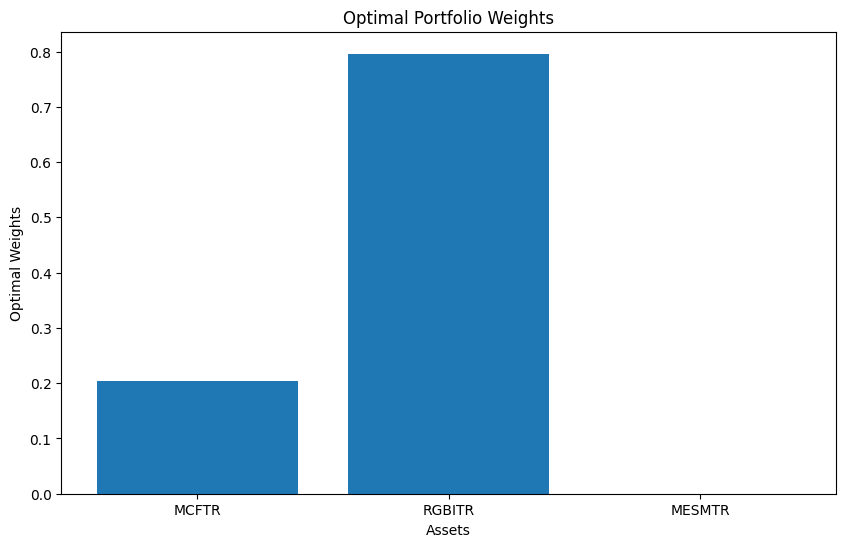

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [57]:
log_returns.mean()

MCFTR     0.000480
RGBITR    0.000234
MESMTR    0.000405
dtype: float64

In [58]:
log_returns.std()

MCFTR     0.015416
RGBITR    0.005389
MESMTR    0.013681
dtype: float64

In [59]:
log_returns_acc = log_returns.cumsum()
log_returns_acc

,MCFTR,RGBITR,MESMTR
TRADEDATE,,,
2014-01-06,-0.025541,0.001231,-0.019280
2014-01-08,-0.027919,0.001847,-0.013800
2014-01-09,-0.026187,0.000154,-0.009779
2014-01-10,-0.023427,-0.000431,-0.006887
2014-01-13,-0.017751,0.000647,-0.000547
...,...,...,...
2025-03-26,1.408770,0.669073,1.188655
2025-03-27,1.388764,0.661000,1.162945
2025-03-28,1.369666,0.659869,1.143234


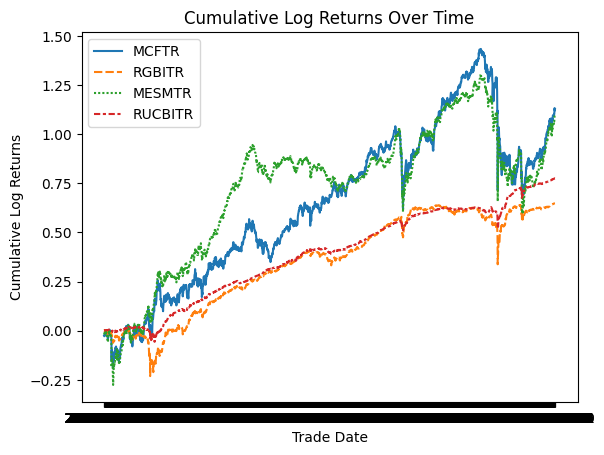

In [44]:
import seaborn as sns

sns.lineplot(data=log_returns_acc)
plt.xlabel('Trade Date')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns Over Time')
plt.show()

In [45]:
import plotly.express as px
import plotly.graph_objects as go

# Генерация случайных портфелей
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
random_weights_list = []

for i in range(num_portfolios):
    weights = np.random.uniform(0.05, 0.5, len(tickers))  # Учитываем границы весов
    weights /= np.sum(weights)  # Нормируем веса до 1

    random_weights_list.append(weights)
    port_return = expected_return(weights, log_returns)
    port_volatility = standard_deviation(weights, cov_matrix)
    port_sharpe = (port_return - risk_free_rate) / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = port_sharpe

# Находим портфель с минимальной волатильностью
min_vol_index = np.argmin(results[1])
min_vol_weights = random_weights_list[min_vol_index]

min_vol_return = results[0, min_vol_index]
min_vol_volatility = results[1, min_vol_index]


# Создаем DataFrame для портфелей
portfolio_df = pd.DataFrame({
    "Return": results[0, :],
    "Volatility": results[1, :],
    "Sharpe Ratio": results[2, :]
})

# Интерактивный scatter plot (эффективная граница)
fig = px.scatter(portfolio_df, 
                 x="Volatility", 
                 y="Return", 
                 color="Sharpe Ratio",
                 color_continuous_scale="viridis",
                 hover_data={"Volatility": True, "Return": True, "Sharpe Ratio": True},
                 title="Efficient Frontier (Interactive)")

# Добавляем точку портфеля с максимальным Sharpe Ratio
fig.add_trace(go.Scatter(
    x=[optimal_portfolio_volatility],
    y=[optimal_portfolio_return],
    mode="markers",
    marker=dict(color="red", size=12, symbol="star"),
    name="Max Sharpe Portfolio"
))

# Добавляем точку портфеля с минимальной волатильностью
fig.add_trace(go.Scatter(
    x=[min_vol_volatility],
    y=[min_vol_return],
    mode="markers",
    marker=dict(color="blue", size=12, symbol="x"),
    name="Min Volatility Portfolio"
))

# Настройки осей
fig.update_layout(xaxis_title="Volatility (Risk)", 
                  yaxis_title="Expected Return",
                  template="plotly_white")

# Показываем интерактивный график
fig.show()


In [60]:
#tickers = ['SBMX', 'SBGB', 'SBGD', 'SBMM', 'SBSC', 'SBRB']
tickers = ['MCFTR', 'RGBITR', 'MESMTR']
risk_free_rate = .02
end_date = datetime.today()
start_date = end_date - timedelta(days = 15*365)

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
from data_loader import ticker_prices
from data_loader import index_history

import warnings
warnings.filterwarnings('ignore')


tickers = ['MCFTR', 'RGBITR']
years = 5
risk_free_rate = .02
end_date = datetime.today()
start_date = end_date - timedelta(days = years*365)


data = index_history(tickers, start_date=start_date,end_date = end_date)
data = data.set_index('TRADEDATE')

log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna()

cov_matrix = log_returns.cov() * 252


def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, 
                             initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', 
                             constraints=constraints, 
                             bounds=bounds)


optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
MCFTR: 0.0964
RGBITR: 0.9036
Expected Annual Return: 0.0664
Expected Volatility: 0.0865
Sharpe Ratio: 0.5359
